In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision, Time Series, and Survival Analysis (Lectures 19 to 20) 

**Due date: see the [Apr 07, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [4]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
df.shape

(18249, 13)

In [6]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [7]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [8]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [9]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

The dataset contains multiple rows with the same Date but different region values (e.g., Albany, Atlanta, etc.), indicating separate measurements for each region.

Example: Rows for 2015-12-27 will appear for Albany, Atlanta, etc., with different AveragePrice and volume metrics.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.9+ MB


In [19]:
print(df['region'].unique())
print(len(df['region'].unique()))

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']
54


In [12]:
df['type'].unique()

array(['conventional', 'organic'], dtype=object)

In [15]:
df[df["Date"] == "2015-12-27"]

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
0,2015-12-27,0.99,386100.49,292097.36,27350.92,297.90,66354.31,48605.95,17748.36,0.00,conventional,2015,Atlanta
0,2015-12-27,1.17,596819.40,40450.49,394104.02,17353.79,144911.10,142543.88,2367.22,0.00,conventional,2015,BaltimoreWashington
0,2015-12-27,0.97,62909.69,30482.25,2971.94,5894.40,23561.10,23520.19,5.69,35.22,conventional,2015,Boise
0,2015-12-27,1.13,450816.39,3886.27,346964.70,13952.56,86012.86,85913.60,99.26,0.00,conventional,2015,Boston
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2015-12-27,1.54,1652.19,0.00,73.22,0.00,1578.97,1336.27,242.70,0.00,organic,2015,Syracuse
0,2015-12-27,1.63,2161.84,874.75,17.54,0.00,1269.55,1216.67,52.88,0.00,organic,2015,Tampa
0,2015-12-27,1.52,549787.59,89709.92,206198.62,5836.04,248043.01,142262.93,105780.08,0.00,organic,2015,TotalUS
0,2015-12-27,1.46,142710.36,29880.32,48416.71,38.63,64374.70,17464.54,46910.16,0.00,organic,2015,West


It looks like for any given date we have made measurements for each region and type of avocado. So for our example data above (2015-12-27) we see 108 row entries when we filter by date, which correlate to 54 regions times 2 types resulting in 108 total measurements.

In [21]:
duplicate_dates = df.duplicated(subset=['Date'], keep=False)
regions_per_date = df[duplicate_dates].groupby('Date')['region'].nunique()
types_per_date = df[duplicate_dates].groupby('Date')['type'].nunique()

print("Number of regions per date:")
print(regions_per_date.head())

print("Number of types per date:")
print(types_per_date.head())


Number of regions per date:
Date
2015-01-04    54
2015-01-11    54
2015-01-18    54
2015-01-25    54
2015-02-01    54
Name: region, dtype: int64
Number of types per date:
Date
2015-01-04    2
2015-01-11    2
2015-01-18    2
2015-01-25    2
2015-02-01    2
Name: type, dtype: int64


Confirming our thoughts, the output above expressed how we have a seperate measurement for each region and type.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

Lets plot the time spacing distribution for a few regions to check if our measurements are equally spaced

In [47]:
def plot_time_spacing_distribution(df, region="Albany", type = "organic"): #Code taken from lecture 20
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[(df['region'] == region) & (df['type'] == type)]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for Albany:
Date
7 days    168
Name: count, dtype: int64



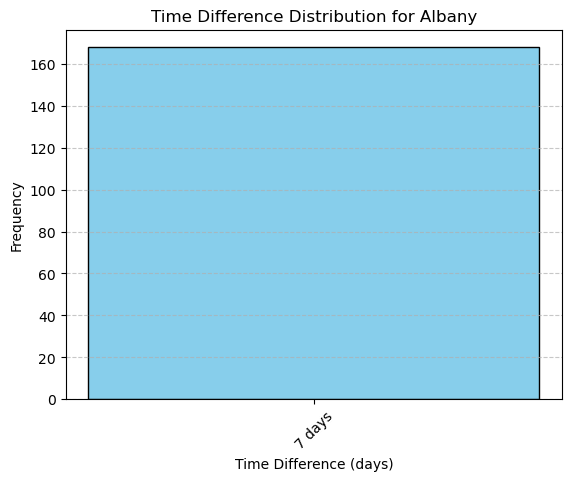

In [48]:
plot_time_spacing_distribution(df)

Time spacing counts for Chicago:
Date
7 days    168
Name: count, dtype: int64



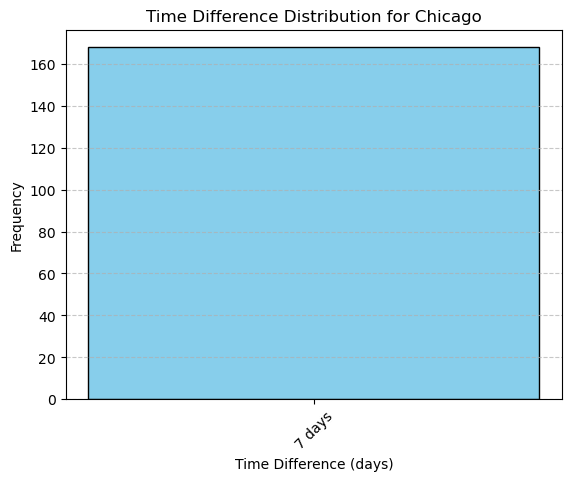

In [49]:
plot_time_spacing_distribution(df, "Chicago")

Time spacing counts for Tampa:
Date
7 days    168
Name: count, dtype: int64



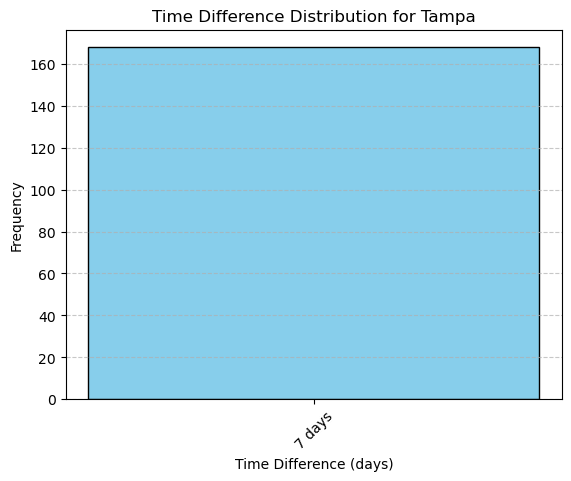

In [50]:
plot_time_spacing_distribution(df, "Tampa")

The dates in the data are very clearly uniformly distributed amongst regions; as we can see from the bar plots above, they all have entries distributed by 7 days. These plots indicate that the measurements are taken strictly weekly at each region for each type of avocado.

In [52]:
df[df["region"] == "Albany"].head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Looking at just the data for the Albany region we can further reaffirm our conclusions as we see the entries are spaced out by 7 days.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [53]:
df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

**1. Clearly Distinct Metro Areas (No Overlap)**  
`Albany`, `Boise`, `Chicago`, `Detroit`, `Houston`

**2. Combined Metro Areas (Potential Overlap)**  
- `BaltimoreWashington`
- `DallasFtWorth` (Dallas + Fort Worth)  
- `MiamiFtLauderdale` (Merged South Florida)  

**3. Aggregate Regions (Definite Overlap)**
- `California` (includes `LosAngeles`, `SanDiego`, `SanFrancisco`)  
- `Southeast` (includes `Atlanta`, `Charlotte`, `Orlando`)  
- `TotalUS` (sum of all regions)  
**Why problematic**:  
- `LosAngeles` data is **double-counted** in both `LosAngeles` and `California`.  
- `TotalUS` includes all other regions, making it unusable alongside them.


### Summmary
| Aggregate Region         | Possible Included Sub-Regions                          |
|--------------------------|--------------------------------------------------------|
| `TotalUS`                | Includes all U.S. regions (entire dataset summarized)  |
| `West`                   | Likely includes `California`, `LosAngeles`, `SanDiego`, `SanFrancisco`, etc. |
| `Northeast`              | Likely includes `NewYork`, `Boston`, `Philadelphia`, `HartfordSpringfield` |
| `GreatLakes`             | Could include `Chicago`, `Detroit`, `CincinnatiDayton`, etc. |
| `SouthCentral`           | Could include `DallasFtWorth`, `Houston`, `WestTexNewMexico` |
| `Midsouth`               | May overlap with `Nashville`, `Louisville`, `Jacksonville` |
| `Southeast`              | May overlap with `MiamiFtLauderdale`, `Tampa`, `Atlanta`, etc. |
| `Plains`                 | Could include `StLouis`, `Indianapolis`, `Kansas City` (if it existed) |

We could potentially see a lot of overlap, although a lot of it is ambiguous because we don't specifically know what states are defined as "West" or "Southeast" etc

---

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures), with some improvements.

In [ ]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [ ]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [ ]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [ ]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [ ]:
train_r2 = None

...

In [ ]:
test_r2 = None

...

In [ ]:
...

In [ ]:
...

In [ ]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

# <!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. In a hospital emergency room, patient vital signs like heart rate or blood pressure might be recorded only when a nurse or doctor checks the patient's vital signs, rather than being regularly monitored. If a patient is in critical condition, their vitals may be recorded every half hour while a stable patient's vitals may only be recorded once every couple of hours. This leads to unequal spacing in time series.
2. Creating lagged versions of features assumes that the data points are recorded at consistent, regular intervals. When the time points are unequally spaced, the concept of a lag becomes ambiguous. There may be no data for that specific time offset, or the actual time difference between lags could vary, leading to misleading or incorrect relations. Therefore, creating lagged versions of features would struggle with unequally spaced time points.
3. When we used time as a numeric feature, the Ridge regression model assumed a linear relationship between the time of the day and the target variable. However, time of day is inherently cyclical, cause after 23 comes 0, which is a continuation. Linear models do not capture this circular pattern, so performance suffers. To tackle this problem we used sine and cosine functions to encode its cyclical nature.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. In a four-class classification problem using sklearn's LogisticRegression() model with 10 features, the model will learn a total of 44 parameters. The model fits one binary classifier per class, where each classifier learns to distinguish one class from the rest. For each of the four classes, the model will learn 10 coefficients for each feature and one intercept, resulting in 11 parameters per class. Therefore, resulting in 44 parameters in total since there are 4 classes.
2. Neural networks act like pipelines, with layers transforming data step-by-step. In transfer learning, this is useful because we can reuse the early layers that capture general features (like edges or textures) and only retrain the final layers for a new task. This saves time and data while still achieving good performance.
3. For this task, I would use transfer learning with a pre-trained convolutional neural network, such as ResNet, and fine-tune it on the dataset. As discussed in Lecture 19, transfer learning works well for small datasets by leveraging general image features learned from large datasets, which improves accuracy and reduces the need for extensive training data.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2.3 Survival analysis
<hr>

rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? Briefly explain your answer. 
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 6

1. Using binary classification to predict churn oversimplifies the problem by ignoring the timing of churn and the issue of right-censoring, where customers who have not churned yet are treated as if they never will. This leads to biased models and lost temporal insights, such as how long a customer will likely stay. Survival analysis addresses these issues by modeling time-to-event directly, handling censoring properly, and providing more informative outputs like survival probabilities and the impact of features on churn risk.
2. Based on the Kaplan and Meier survival curve analysis, Customer A, who just joined last week, is more likely to leave the service first compared to Customer B, who has been with the service for a year. The early months show a steep drop in survival probability, indicating higher churn rates for new customers like A. In contrast, Customer B has already passed the high-risk phase, as survival probability stabilizes for customers who stay beyond the first year. This data supports the conclusion that Customer A is at a higher risk of leaving first.
3. A flat survival function during a certain period indicates that the probability of the event occurring is very low during that time. In other words, customers are less likely to churn during that specific period.

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)